# Auto-Reading

['Record Information', 'Measurements', 'RVC Events', 'System alarms', 'Record Starting Conditions']
            Time [UTC]  u0(Avg) [%]  Pst1(Avg) []  Pst2(Avg) []  Pst3(Avg) []  \
0  1756237380000000000     0.067079           0.0           0.0           0.0   
1  1756237440000000000     0.060927           0.0           0.0           0.0   
2  1756237500000000000     0.061299           0.0           0.0           0.0   
3  1756237560000000000     0.060281           0.0           0.0           0.0   
4  1756237620000000000     0.062140           0.0           0.0           0.0   

   Plt1(Avg) []  Plt2(Avg) []  Plt3(Avg) []  THD U1(AvgOn) [%]  \
0           0.0           0.0           0.0           1.540950   
1           0.0           0.0           0.0           1.541174   
2           0.0           0.0           0.0           1.543531   
3           0.0           0.0           0.0           1.535155   
4           0.0           0.0           0.0           1.538775   

   THD U2(AvgOn)

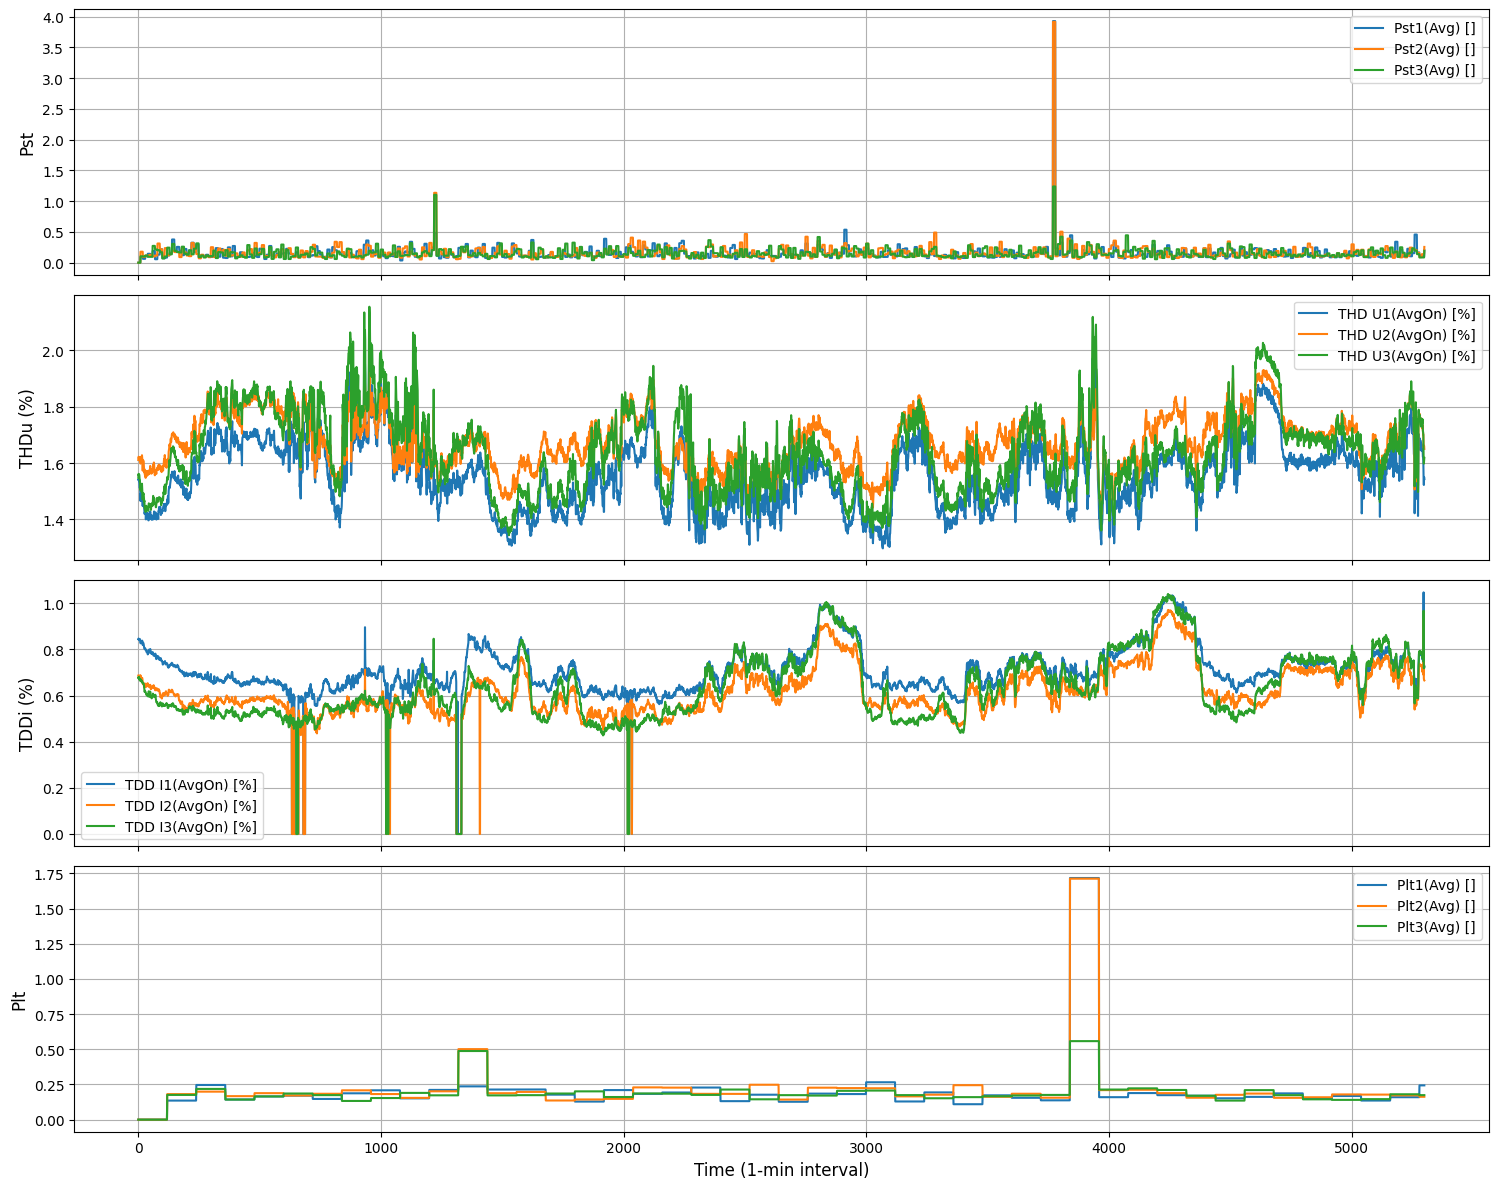

Saved file


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

path = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Data & Report\Data\131 (19h42 26.9 - 12h02 30.8).xlsx"
xls = pd.ExcelFile(path)
print(xls.sheet_names)

data = pd.read_excel(xls, sheet_name=1)
data = data.replace("-", 0)
data = data.apply(pd.to_numeric, errors="ignore")
print(data.head())

cols_pst = ["Pst1(Avg) []", "Pst2(Avg) []", "Pst3(Avg) []"]
cols_thdu = ["THD U1(AvgOn) [%]", "THD U2(AvgOn) [%]", "THD U3(AvgOn) [%]"]
cols_tddi = ["TDD I1(AvgOn) [%]", "TDD I2(AvgOn) [%]", "TDD I3(AvgOn) [%]"]
cols_plt = ["Plt1(Avg) []", "Plt2(Avg) []", "Plt3(Avg) []"]

thresholds = {
    "Pst1(Avg) []": 0.8,
    "Pst2(Avg) []": 0.8,
    "Pst3(Avg) []": 0.8,
    "THD U1(AvgOn) [%]": 3,
    "THD U2(AvgOn) [%]": 3,
    "THD U3(AvgOn) [%]": 3,
    "TDD I1(AvgOn) [%]": 3,
    "TDD I2(AvgOn) [%]": 3,
    "TDD I3(AvgOn) [%]": 3,
    "Plt1(Avg) []": 0.6,
    "Plt2(Avg) []": 0.6,
    "Plt3(Avg) []": 0.6
}

data = data.replace("-", pd.NA)
for col in thresholds.keys():
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")
    else:
        data[col] = pd.Series(dtype="float64")

def make_table(cols, group_name):
    df = data[cols]
    total = df.count()
    passed = pd.Series({c: int(((df[c] <= thresholds[c]) & df[c].notna()).sum()) for c in cols})
    failed = total - passed
    perc = (passed / total.replace(0, np.nan) * 100).round(2).fillna(0)
    status_per_col = perc.apply(lambda x: "PASS" if x >= 95 else "FAIL")
    group_status = "PASS" if (status_per_col == "PASS").all() else "FAIL"
    df_result = pd.DataFrame([
        total.astype(int),
        passed.astype(int),
        failed.astype(int),
        perc,
        status_per_col
    ], index=[
        "No. of samples",
        "No. of pass samples",
        "No. of fail samples",
        "Percentage of pass samples [%]",
        "Status"
    ])
    
    df_result.loc["Group Status"] = [group_status] * len(df_result.columns)
    
    print(f"\n===== {group_name} =====")
    print(df_result)
    return df_result

table_pst = make_table(cols_pst, "Pst")
table_thdu = make_table(cols_thdu, "THDu")
table_tddi = make_table(cols_tddi, "TDDi")
table_plt = make_table(cols_plt, "Plt")

#PLOTTING
groups = {
    "Pst": cols_pst,
    "THDu (%)": cols_thdu,
    "TDDi (%)": cols_tddi,
    "Plt": cols_plt
}
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
for ax, (title, cols) in zip(axes, groups.items()):
    for col in cols:
        ax.plot(data[col], label=col)
    ax.set_ylabel(title, fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True)
axes[-1].set_xlabel("Time (1-min interval)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

 #SAVE EXCEL
from openpyxl.styles import Alignment
from openpyxl import Workbook

def save_table_to_excel(writer, df, group_name, col_letters):
    df_copy = df.copy()
    df_copy.columns = col_letters
    df_copy.to_excel(writer, sheet_name=group_name+"_summary", index=True, startrow=1)
    worksheet = writer.sheets[group_name+"_summary"]
    last_col = len(df_copy.columns) + 1 
    merge_range = f"A1:{chr(64+last_col)}1" 
    worksheet.merge_cells(merge_range)
    
    cell = worksheet.cell(row=1, column=1)
    cell.value = group_name
    cell.alignment = Alignment(horizontal='center', vertical='center')

cols_letters = {
    "Pst": ["A", "B", "C"],
    "THDu": ["A", "B", "C"],
    "TDDi": ["A", "B", "C"],
    "Plt": ["A", "B", "C"]
}

with pd.ExcelWriter(rf"results_summary.xlsx", engine="openpyxl") as writer:
    save_table_to_excel(writer, table_pst, "Pst", cols_letters["Pst"])
    save_table_to_excel(writer, table_thdu, "THDu (%)", cols_letters["THDu"])
    save_table_to_excel(writer, table_tddi, "TDDi (%)", cols_letters["TDDi"])
    save_table_to_excel(writer, table_plt, "Plt", cols_letters["Plt"])

print("Saved file")

In [ ]:
with pd.ExcelWriter("results_summary.xlsx", engine="openpyxl") as writer:
    table_pst.to_excel(writer, sheet_name="Pst_summary")
    table_thdu.to_excel(writer, sheet_name="THDu_summary")
    table_tddi.to_excel(writer, sheet_name="TDDi_summary")
    table_plt.to_excel(writer, sheet_name="Plt_summary")
print("\nĐã lưu file 'results_summary.xlsx' với 4 sheet: Pst_summary, THDu_summary, TDDi_summary, Plt_summary")


Đã lưu file 'results_summary.xlsx' với 4 sheet: Pst_summary, THDu_summary, TDDi_summary, Plt_summary


In [ ]:
# from openpyxl.styles import Alignment
# from openpyxl import Workbook

# def save_table_to_excel(writer, df, group_name, col_letters):
#     df_copy = df.copy()
#     df_copy.columns = col_letters
#     df_copy.to_excel(writer, sheet_name=group_name+"_summary", index=True, startrow=1)
#     worksheet = writer.sheets[group_name+"_summary"]
#     last_col = len(df_copy.columns) + 1  # +1 vì index
#     merge_range = f"A1:{chr(64+last_col)}1"  # Ví dụ A1:C1
#     worksheet.merge_cells(merge_range)
    
#     cell = worksheet.cell(row=1, column=1)
#     cell.value = group_name
#     cell.alignment = Alignment(horizontal='center', vertical='center')

# cols_letters = {
#     "Pst": ["A", "B", "C"],
#     "THDu": ["A", "B", "C"],
#     "TDDi": ["A", "B", "C"],
#     "Plt": ["A", "B", "C"]
# }

# with pd.ExcelWriter(rf"C:\Users\This PC\Downloads\test.xlsx", engine="openpyxl") as writer:
#     save_table_to_excel(writer, table_pst, "Pst", cols_letters["Pst"])
#     save_table_to_excel(writer, table_thdu, "THDu (%)", cols_letters["THDu"])
#     save_table_to_excel(writer, table_tddi, "TDDi (%)", cols_letters["TDDi"])
#     save_table_to_excel(writer, table_plt, "Plt", cols_letters["Plt"])

# print("Đã lưu file 'results_summary.xlsx' với header nhóm merge và cột A/B/C")

Đã lưu file 'results_summary.xlsx' với header nhóm merge và cột A/B/C


In [ ]:
# import pandas as pd

# data = pd.read_excel(xls, sheet_name=1)
# first_col = data.columns[0]
# print("Name:", first_col)
# print("Data Type:", data[first_col].dtype)

# if pd.api.types.is_datetime64_any_dtype(data[first_col]):
#     print("Cột đầu tiên đã ở định dạng datetime.")
# else:
#     print("Cột đầu tiên chưa ở định dạng datetime.")
#     data[first_col] = pd.to_datetime(data[first_col], errors="coerce")
#     print("Đã convert sang datetime (nếu dữ liệu hợp lệ).")

Name: Time [UTC]
Data Type: datetime64[ns]
Cột đầu tiên đã ở định dạng datetime.


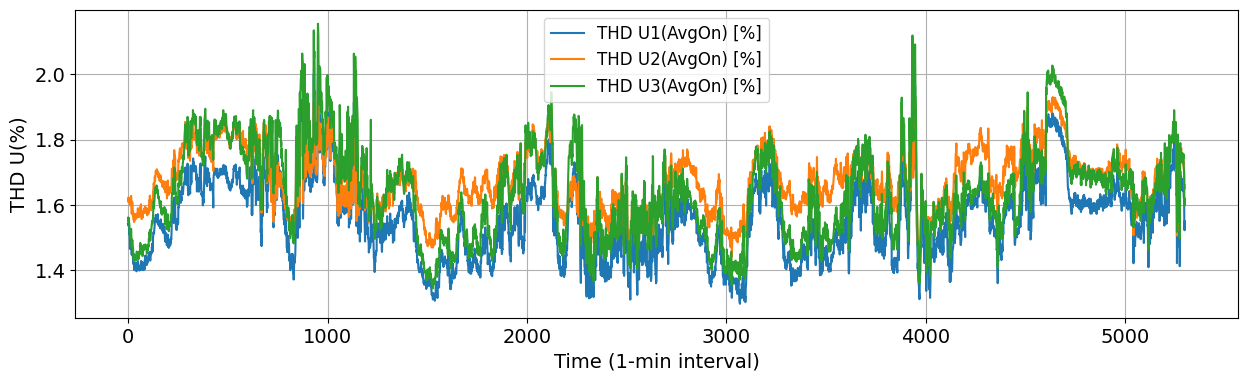

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
# cols_pst = ["Plt1(Avg) []", "Plt2(Avg) []", "Plt3(Avg) []"]
# cols_pst = ["TDD I1(AvgOn) [%]", "TDD I2(AvgOn) [%]", "TDD I3(AvgOn) [%]"]
cols_pst = ["THD U1(AvgOn) [%]", "THD U2(AvgOn) [%]", "THD U3(AvgOn) [%]"]
for col in cols_pst:
    plt.plot(data[col], label=col)
plt.xlabel('Time (1-min interval)', fontsize=14)
plt.ylabel('THD U(%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


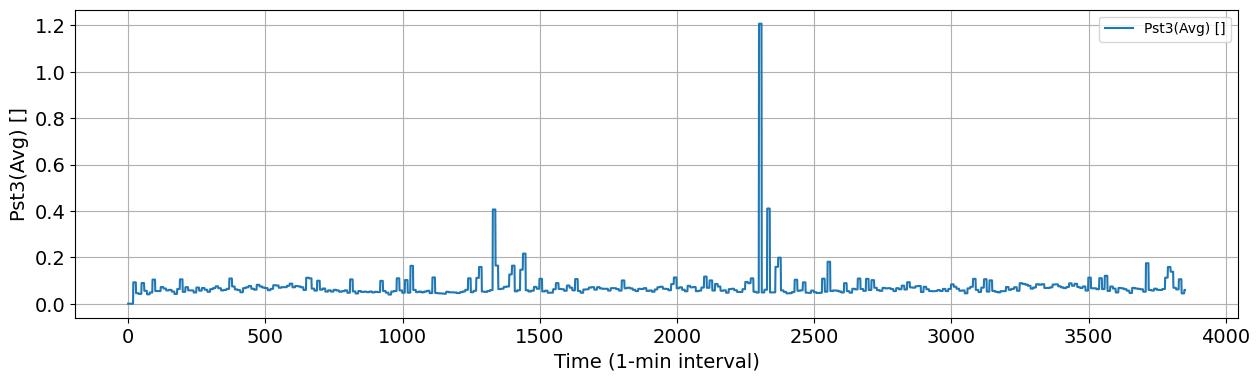

In [76]:
plt.figure(figsize=(15, 4))
lb ='Pst3(Avg) []'
plt.plot(data[lb], label=lb)
plt.xlabel('Time (1-min interval)', fontsize=14)
plt.ylabel(lb, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()
plt.show()


# Folder

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from openpyxl.styles import Alignment

warnings.filterwarnings('ignore')
# === CONFIG ===
folder_path = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Data & Report\Data"
output_folder = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output"
os.makedirs(output_folder, exist_ok=True)
 
# === CÁC CỘT VÀ NGƯỠNG ===
cols_pst = ["Pst1(Avg) []", "Pst2(Avg) []", "Pst3(Avg) []"]
cols_thdu = ["THD U1(AvgOn) [%]", "THD U2(AvgOn) [%]", "THD U3(AvgOn) [%]"]
cols_tddi = ["TDD I1(AvgOn) [%]", "TDD I2(AvgOn) [%]", "TDD I3(AvgOn) [%]"]
cols_plt = ["Plt1(Avg) []", "Plt2(Avg) []", "Plt3(Avg) []"]

thresholds = {
    "Pst1(Avg) []": 0.8, "Pst2(Avg) []": 0.8, "Pst3(Avg) []": 0.8,
    "THD U1(AvgOn) [%]": 3, "THD U2(AvgOn) [%]": 3, "THD U3(AvgOn) [%]": 3,
    "TDD I1(AvgOn) [%]": 3, "TDD I2(AvgOn) [%]": 3, "TDD I3(AvgOn) [%]": 3,
    "Plt1(Avg) []": 0.6, "Plt2(Avg) []": 0.6, "Plt3(Avg) []": 0.6
}

# === HÀM PHỤ ===
def make_table(data, cols, group_name):
    df = data[cols]
    total = df.count()
    passed = pd.Series({c: int(((df[c] <= thresholds[c]) & df[c].notna()).sum()) for c in cols})
    failed = total - passed
    perc = (passed / total.replace(0, np.nan) * 100).round(2).fillna(0)
    status_per_col = perc.apply(lambda x: "PASS" if x >= 95 else "FAIL")
    group_status = "PASS" if (status_per_col == "PASS").all() else "FAIL"
    df_result = pd.DataFrame([
        total.astype(int),
        passed.astype(int),
        failed.astype(int),
        perc,
        status_per_col
    ], index=[
        "No. of samples",
        "No. of pass samples",
        "No. of fail samples",
        "Percentage of pass samples [%]",
        "Status"
    ])
    df_result.loc["Group Status"] = [group_status] * len(df_result.columns)
    return df_result

def save_table_to_excel(writer, df, group_name):
    df_copy = df.copy()
    df_copy.to_excel(writer, sheet_name=group_name+"_summary", index=True, startrow=1)
    worksheet = writer.sheets[group_name+"_summary"]
    last_col = len(df_copy.columns) + 1 
    merge_range = f"A1:{chr(64+last_col)}1"
    worksheet.merge_cells(merge_range)
    cell = worksheet.cell(row=1, column=1)
    cell.value = group_name
    cell.alignment = Alignment(horizontal='center', vertical='center')

def plot_and_save(data, file_name):
    groups = {
        "Pst": cols_pst,
        "THDu (%)": cols_thdu,
        "TDDi (%)": cols_tddi,
        "Plt": cols_plt
    }
    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    for ax, (title, cols) in zip(axes, groups.items()):
        for col in cols:
            ax.plot(data[col], label=col)
        ax.set_ylabel(title, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    axes[-1].set_xlabel("Time (1-min interval)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    fig_path = os.path.join(output_folder, f"Output_{file_name}.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"📊 Đã lưu hình: {fig_path}")

# === MAIN LOOP ===
files = glob.glob(os.path.join(folder_path, "*.xlsx"))

for file in files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    out_excel = os.path.join(output_folder, f"Output_{base_name}.xlsx")
    out_png   = os.path.join(output_folder, f"Output_{base_name}.png")

    # Nếu đã có cả Excel và PNG thì bỏ qua
    if os.path.exists(out_excel) and os.path.exists(out_png):
        print(f"⏩ Bỏ qua (đã xử lý): {base_name}")
        continue

    print(f"🔄 Đang xử lý: {base_name}")
    try:
        xls = pd.ExcelFile(file)
        data = pd.read_excel(xls, sheet_name=1)
        data = data.replace("-", pd.NA)
        for col in thresholds.keys():
            if col in data.columns:
                data[col] = pd.to_numeric(data[col], errors="coerce")
            else:
                data[col] = pd.Series(dtype="float64")

        # tạo summary tables
        table_pst = make_table(data, cols_pst, "Pst")
        table_thdu = make_table(data, cols_thdu, "THDu")
        table_tddi = make_table(data, cols_tddi, "TDDi")
        table_plt = make_table(data, cols_plt, "Plt")

        # Lưu Excel
        with pd.ExcelWriter(out_excel, engine="openpyxl") as writer:
            save_table_to_excel(writer, table_pst, "Pst")
            save_table_to_excel(writer, table_thdu, "THDu")
            save_table_to_excel(writer, table_tddi, "TDDi")
            save_table_to_excel(writer, table_plt, "Plt")
        print(f"✅ Đã lưu Excel: {out_excel}")

        # Lưu hình
        plot_and_save(data, base_name)
    except Exception as e:
        print(f"❌ Lỗi khi xử lý {file}: {e}")

🔄 Đang xử lý: 131 (19h42 26.9 - 12h02 30.8)
✅ Đã lưu Excel: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_131 (19h42 26.9 - 12h02 30.8).xlsx
📊 Đã lưu hình: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_131 (19h42 26.9 - 12h02 30.8).png
⏩ Bỏ qua (đã xử lý): 132 (14h09 29.8 - 12h28 30.8)
⏩ Bỏ qua (đã xử lý): 132 (16h28 28.8 - 13h32 29.8)
⏩ Bỏ qua (đã xử lý): 132 (20h20 27.8 - 14h25 28.8)
⏩ Bỏ qua (đã xử lý): 133 (20h10 27.8 - 12h22 30.8)
⏩ Bỏ qua (đã xử lý): WT (20h01 26.8 - 6h50 27.8)


<< Save PDF >>

In [157]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from openpyxl.styles import Alignment

# PDF
from reportlab.lib.pagesizes import A4, portrait
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

warnings.filterwarnings('ignore')

# === CONFIG ===
folder_path = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Data & Report\Data" #input folder
output_folder = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output"
os.makedirs(output_folder, exist_ok=True)

# === CÁC CỘT VÀ NGƯỠNG ===
cols_pst = ["Pst1(Avg) []", "Pst2(Avg) []", "Pst3(Avg) []"]
cols_thdu = ["THD U1(AvgOn) [%]", "THD U2(AvgOn) [%]", "THD U3(AvgOn) [%]"]
cols_tddi = ["TDD I1(AvgOn) [%]", "TDD I2(AvgOn) [%]", "TDD I3(AvgOn) [%]"]
cols_plt = ["Plt1(Avg) []", "Plt2(Avg) []", "Plt3(Avg) []"]

thresholds = {
    "Pst1(Avg) []": 0.8, "Pst2(Avg) []": 0.8, "Pst3(Avg) []": 0.8,
    "THD U1(AvgOn) [%]": 3, "THD U2(AvgOn) [%]": 3, "THD U3(AvgOn) [%]": 3,
    "TDD I1(AvgOn) [%]": 3, "TDD I2(AvgOn) [%]": 3, "TDD I3(AvgOn) [%]": 3,
    "Plt1(Avg) []": 0.6, "Plt2(Avg) []": 0.6, "Plt3(Avg) []": 0.6
}

# === Đăng ký font Times New Roman ===
try:
    pdfmetrics.registerFont(TTFont('Times-Roman', 'times.ttf'))  # cần có file times.ttf
except:
    print("⚠️ Không tìm thấy times.ttf, sẽ dùng font mặc định.")

# === HÀM PHỤ ===
def make_table(data, cols, group_name):
    df = data[cols]
    total = df.count()
    passed = pd.Series({c: int(((df[c] <= thresholds[c]) & df[c].notna()).sum()) for c in cols})
    failed = total - passed
    perc = (passed / total.replace(0, np.nan) * 100).round(2).fillna(0)
    status_per_col = perc.apply(lambda x: "PASS" if x >= 95 else "FAIL")
    group_status = "PASS" if (status_per_col == "PASS").all() else "FAIL"
    df_result = pd.DataFrame([
        total.astype(int),
        passed.astype(int),
        failed.astype(int),
        perc,
        status_per_col
    ], index=[
        "No. of samples",
        "No. of pass samples",
        "No. of fail samples",
        "Percentage of pass samples [%]",
        "Status"
    ])
    df_result.loc["Group Status"] = [group_status] * len(df_result.columns)
    return df_result

def save_table_to_excel(writer, df, group_name):
    df_copy = df.copy()
    df_copy.to_excel(writer, sheet_name=group_name+"_summary", index=True, startrow=1)
    worksheet = writer.sheets[group_name+"_summary"]
    last_col = len(df_copy.columns) + 1 
    merge_range = f"A1:{chr(64+last_col)}1"
    worksheet.merge_cells(merge_range)
    cell = worksheet.cell(row=1, column=1)
    cell.value = group_name
    cell.alignment = Alignment(horizontal='center', vertical='center')

def plot_and_save(data, file_name):
    groups = {
        "Pst": cols_pst,
        "THDu (%)": cols_thdu,
        "TDDi (%)": cols_tddi,
        "Plt": cols_plt
    }
    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    for ax, (title, cols) in zip(axes, groups.items()):
        for col in cols:
            ax.plot(data[col], label=col)
        ax.set_ylabel(title, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    axes[-1].set_xlabel("Time (1-min interval)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    fig_path = os.path.join(output_folder, f"Output_{file_name}.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Đã lưu hình: {fig_path}")

def save_pdf(tables, out_pdf, base_name):
    doc = SimpleDocTemplate(out_pdf, pagesize=portrait(A4))
    elements = []
    styles = getSampleStyleSheet()

    # Dùng Times New Roman
    styles['Title'].fontName = 'Times-Roman'
    styles['Heading2'].fontName = 'Times-Roman'
    styles['Normal'].fontName = 'Times-Roman'

    # Tiêu đề
    title = Paragraph(f"Summary Report - {base_name}", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 20))
    
    for group_name, df in tables.items():
        subtitle = Paragraph(group_name, styles['Heading2'])
        elements.append(subtitle)
        elements.append(Spacer(1, 10))
        
        # header
        data_table = [ [df.index.name or "Metric"] + df.columns.tolist() ]
        for idx, row in df.iterrows():
            row_data = [idx] + row.astype(str).tolist()
            data_table.append(row_data)
        
        t = Table(data_table, hAlign="CENTER")
        
        # Style mặc định
        style_list = [
            ('FONTNAME', (0,0), (-1,-1), 'Times-Roman'),
            ('ALIGN', (0,0), (-1,-1), 'CENTER'),
            ('BACKGROUND', (0,0), (-1,-1), colors.white),
            ('TEXTCOLOR', (0,0), (-1,-1), colors.black),
            ('GRID', (0,0), (-1,-1), 0.5, colors.black),
        ]
        
        # Tô màu PASS/FAIL
        for r, row in enumerate(data_table[1:], start=1):
            for c, val in enumerate(row):
                if val == "PASS":
                    style_list.append(('TEXTCOLOR', (c, r), (c, r), colors.green))
                elif val == "FAIL":
                    style_list.append(('TEXTCOLOR', (c, r), (c, r), colors.red))
        
        t.setStyle(TableStyle(style_list))
        elements.append(t)
        elements.append(Spacer(1, 20))
    
    doc.build(elements)
    print(f"Đã lưu PDF: {out_pdf}")

# === MAIN LOOP ===
files = glob.glob(os.path.join(folder_path, "*.xlsx"))

for file in files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    out_excel = os.path.join(output_folder, f"Output_{base_name}.xlsx")
    out_png   = os.path.join(output_folder, f"Output_{base_name}.png")
    out_pdf   = os.path.join(output_folder, f"Output_{base_name}.pdf")

    # Nếu đã có cả Excel và PNG và PDF thì bỏ qua
    if os.path.exists(out_excel) and os.path.exists(out_png) and os.path.exists(out_pdf):
        print(f"Bỏ qua (đã xử lý): {base_name}")
        continue

    print(f"Đang xử lý: {base_name}")
    try:
        xls = pd.ExcelFile(file)
        data = pd.read_excel(xls, sheet_name=1)

        # Xử lý missing values (trừ cột Time [UTC])
        if "Time [UTC]" in data.columns:
            time_col = data["Time [UTC]"]
            data = data.drop(columns=["Time [UTC]"])
        else:
            time_col = None

        data = data.replace("-", 0).fillna(0)
        data = data.apply(pd.to_numeric, errors="ignore")

        if time_col is not None:
            data.insert(0, "Time [UTC]", time_col)

        # tạo summary tables
        table_pst = make_table(data, cols_pst, "Pst")
        table_thdu = make_table(data, cols_thdu, "THDu")
        table_tddi = make_table(data, cols_tddi, "TDDi")
        table_plt = make_table(data, cols_plt, "Plt")

        # Lưu Excel
        with pd.ExcelWriter(out_excel, engine="openpyxl") as writer:
            save_table_to_excel(writer, table_pst, "Pst")
            save_table_to_excel(writer, table_thdu, "THDu")
            save_table_to_excel(writer, table_tddi, "TDDi")
            save_table_to_excel(writer, table_plt, "Plt")
        print(f"Đã lưu Excel: {out_excel}")

        # Lưu hình
        plot_and_save(data, base_name)

        # Lưu PDF
        tables = {
            "Pst": table_pst,
            "THDu": table_thdu,
            "TDDi": table_tddi,
            "Plt": table_plt
        }
        save_pdf(tables, out_pdf, base_name)

    except Exception as e:
        print(f"Lỗi khi xử lý {file}: {e}")


Đang xử lý: 131 (19h42 26.9 - 12h02 30.8)
Đã lưu Excel: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_131 (19h42 26.9 - 12h02 30.8).xlsx
Đã lưu hình: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_131 (19h42 26.9 - 12h02 30.8).png
Đã lưu PDF: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_131 (19h42 26.9 - 12h02 30.8).pdf
Đang xử lý: 132 (14h09 29.8 - 12h28 30.8)
Đã lưu Excel: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_132 (14h09 29.8 - 12h28 30.8).xlsx
Đã lưu hình: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_132 (14h09 29.8 - 12h28 30.8).png
Đã lưu PDF: C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output\Output_132 (14h09 29.8 - 12h28 30.8).pdf
Đang xử lý: 13

In [146]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from openpyxl.styles import Alignment

# PDF
from reportlab.lib.pagesizes import A4, landscape
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

warnings.filterwarnings('ignore')

# === CONFIG ===
folder_path = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Data & Report\Data"
output_folder = r"C:\Users\This PC\OneDrive - TNDigi Digital Marketing\Attachments\Uyen\SVN\Task\2. Task 2\Output"
os.makedirs(output_folder, exist_ok=True)

# === CÁC CỘT VÀ NGƯỠNG ===
cols_pst = ["Pst1(Avg) []", "Pst2(Avg) []", "Pst3(Avg) []"]
cols_thdu = ["THD U1(AvgOn) [%]", "THD U2(AvgOn) [%]", "THD U3(AvgOn) [%]"]
cols_tddi = ["TDD I1(AvgOn) [%]", "TDD I2(AvgOn) [%]", "TDD I3(AvgOn) [%]"]
cols_plt = ["Plt1(Avg) []", "Plt2(Avg) []", "Plt3(Avg) []"]

thresholds = {
    "Pst1(Avg) []": 0.8, "Pst2(Avg) []": 0.8, "Pst3(Avg) []": 0.8,
    "THD U1(AvgOn) [%]": 3, "THD U2(AvgOn) [%]": 3, "THD U3(AvgOn) [%]": 3,
    "TDD I1(AvgOn) [%]": 3, "TDD I2(AvgOn) [%]": 3, "TDD I3(AvgOn) [%]": 3,
    "Plt1(Avg) []": 0.6, "Plt2(Avg) []": 0.6, "Plt3(Avg) []": 0.6
}

# === HÀM PHỤ ===
def make_table(data, cols, group_name):
    df = data[cols]
    total = df.count()
    passed = pd.Series({c: int(((df[c] <= thresholds[c]) & df[c].notna()).sum()) for c in cols})
    failed = total - passed
    perc = (passed / total.replace(0, np.nan) * 100).round(2).fillna(0)
    status_per_col = perc.apply(lambda x: "PASS" if x >= 95 else "FAIL")
    group_status = "PASS" if (status_per_col == "PASS").all() else "FAIL"
    df_result = pd.DataFrame([
        total.astype(int),
        passed.astype(int),
        failed.astype(int),
        perc,
        status_per_col
    ], index=[
        "No. of samples",
        "No. of pass samples",
        "No. of fail samples",
        "Percentage of pass samples [%]",
        "Status"
    ])
    df_result.loc["Group Status"] = [group_status] * len(df_result.columns)
    return df_result

def save_table_to_excel(writer, df, group_name):
    df_copy = df.copy()
    df_copy.to_excel(writer, sheet_name=group_name+"_summary", index=True, startrow=1)
    worksheet = writer.sheets[group_name+"_summary"]
    last_col = len(df_copy.columns) + 1 
    merge_range = f"A1:{chr(64+last_col)}1"
    worksheet.merge_cells(merge_range)
    cell = worksheet.cell(row=1, column=1)
    cell.value = group_name
    cell.alignment = Alignment(horizontal='center', vertical='center')

def plot_and_save(data, file_name):
    groups = {
        "Pst": cols_pst,
        "THDu (%)": cols_thdu,
        "TDDi (%)": cols_tddi,
        "Plt": cols_plt
    }
    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    for ax, (title, cols) in zip(axes, groups.items()):
        for col in cols:
            ax.plot(data[col], label=col)
        ax.set_ylabel(title, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    axes[-1].set_xlabel("Time (1-min interval)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    fig_path = os.path.join(output_folder, f"Output_{file_name}.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Đã lưu hình: {fig_path}")

def save_pdf(tables, out_pdf, base_name):
    doc = SimpleDocTemplate(out_pdf, pagesize=landscape(A4))
    elements = []
    styles = getSampleStyleSheet()
    title = Paragraph(f"Summary Report - {base_name}", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 20))
    
    for group_name, df in tables.items():
        subtitle = Paragraph(group_name, styles['Heading2'])
        elements.append(subtitle)
        elements.append(Spacer(1, 10))
        
        # header
        data_table = [ [df.index.name or "Metric"] + df.columns.tolist() ]
        for idx, row in df.iterrows():
            data_table.append([idx] + row.astype(str).tolist())
        
        t = Table(data_table)
        t.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), colors.grey),
            ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
            ('ALIGN', (0,0), (-1,-1), 'CENTER'),
            ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0,0), (-1,0), 8),
            ('BACKGROUND', (0,1), (-1,-1), colors.beige),
            ('GRID', (0,0), (-1,-1), 0.5, colors.black),
        ]))
        elements.append(t)
        elements.append(Spacer(1, 20))
    
    doc.build(elements)
    print(f"Đã lưu PDF: {out_pdf}")

# === MAIN LOOP ===
files = glob.glob(os.path.join(folder_path, "*.xlsx"))

for file in files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    out_excel = os.path.join(output_folder, f"Output_{base_name}.xlsx")
    out_png   = os.path.join(output_folder, f"Output_{base_name}.png")
    out_pdf   = os.path.join(output_folder, f"Output_{base_name}.pdf")

    # Nếu đã có cả Excel và PNG và PDF thì bỏ qua
    if os.path.exists(out_excel) and os.path.exists(out_png) and os.path.exists(out_pdf):
        print(f"Bỏ qua (đã xử lý): {base_name}")
        continue

    print(f"Đang xử lý: {base_name}")
    try:
        xls = pd.ExcelFile(file)
        data = pd.read_excel(xls, sheet_name=1)
        data = data.replace("-", pd.NA)
        for col in thresholds.keys():
            if col in data.columns:
                data[col] = pd.to_numeric(data[col], errors="coerce")
            else:
                data[col] = pd.Series(dtype="float64")

        # tạo summary tables
        table_pst = make_table(data, cols_pst, "Pst")
        table_thdu = make_table(data, cols_thdu, "THDu")
        table_tddi = make_table(data, cols_tddi, "TDDi")
        table_plt = make_table(data, cols_plt, "Plt")

        # Lưu Excel
        with pd.ExcelWriter(out_excel, engine="openpyxl") as writer:
            save_table_to_excel(writer, table_pst, "Pst")
            save_table_to_excel(writer, table_thdu, "THDu")
            save_table_to_excel(writer, table_tddi, "TDDi")
            save_table_to_excel(writer, table_plt, "Plt")
        print(f"Đã lưu Excel: {out_excel}")

        # Lưu hình
        plot_and_save(data, base_name)

        # Lưu PDF
        tables = {
            "Pst": table_pst,
            "THDu": table_thdu,
            "TDDi": table_tddi,
            "Plt": table_plt
        }
        save_pdf(tables, out_pdf, base_name)

    except Exception as e:
        print(f"Lỗi khi xử lý {file}: {e}")


Bỏ qua (đã xử lý): 131 (19h42 26.9 - 12h02 30.8)
Bỏ qua (đã xử lý): 132 (14h09 29.8 - 12h28 30.8)
Bỏ qua (đã xử lý): 132 (16h28 28.8 - 13h32 29.8)
Bỏ qua (đã xử lý): 132 (20h20 27.8 - 14h25 28.8)
Bỏ qua (đã xử lý): 133 (20h10 27.8 - 12h22 30.8)
Bỏ qua (đã xử lý): WT (20h01 26.8 - 6h50 27.8)
